# Time Series with Recurrent Neural Networks

In [1]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import os

np.random.seed(1729)
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

### Plotting helper functions

In [2]:
def plot_series(df, xlabel=None, ylabel=None, plot_title=''):
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x = df.index, y=df.series,
                             mode='lines', name='Test'))
    xlabel = xlabel if xlabel else 'Time'
    ylabel = ylabel if ylabel else ''
    
    fig.update_layout(xaxis_title=xlabel,
                     yaxis_title=ylabel,
                     template='plotly_dark',
                     title=plot_title 
                     )
    
    fig.show()
    
    
def plot_forecast(train_data, train_index, test_data, test_index, prediction, **kwargs):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=train_index, 
                             y=train_data, 
                             name='Train data'
                            )
                 )



    fig.add_trace(go.Scatter(x=test_index, 
                             y=test_data, 
                             name='Ground truth'
                            )
                 ) 

    fig.add_trace(go.Scatter(x=test_index, 
                             y=prediction, 
                             name='Prediction'
                            )
                 )
    

    fig.update_layout(template='plotly_dark',
                      title=kwargs.get('plot_title', None)
                     )
    
    
    fig.show() 
    
    

## Generating time sequence data

In [3]:
def generate_series(length):
    df = pd.DataFrame(0, index=np.arange(0, length), columns=['series']) 
    df.index.name = 'time'
    return df

def white_noise(df, mu=0, sigma=1):
    df.series += sigma * np.random.randn(df.series.shape[0]) + mu
    return df

def trend(df, slope=1/365):
    df.series += slope * df.index
    return df

def seasonality(df, period=100, offset=0, scale=1):
    # Random periodic function
    f = lambda x: np.sin(x) + 1/6 * np.sin(2 * x) - 1/3 *  np.sin(3 * x)
    time = scale * f(2 * np.pi / period * df.index + offset)
    df.series += time 
    return df
    

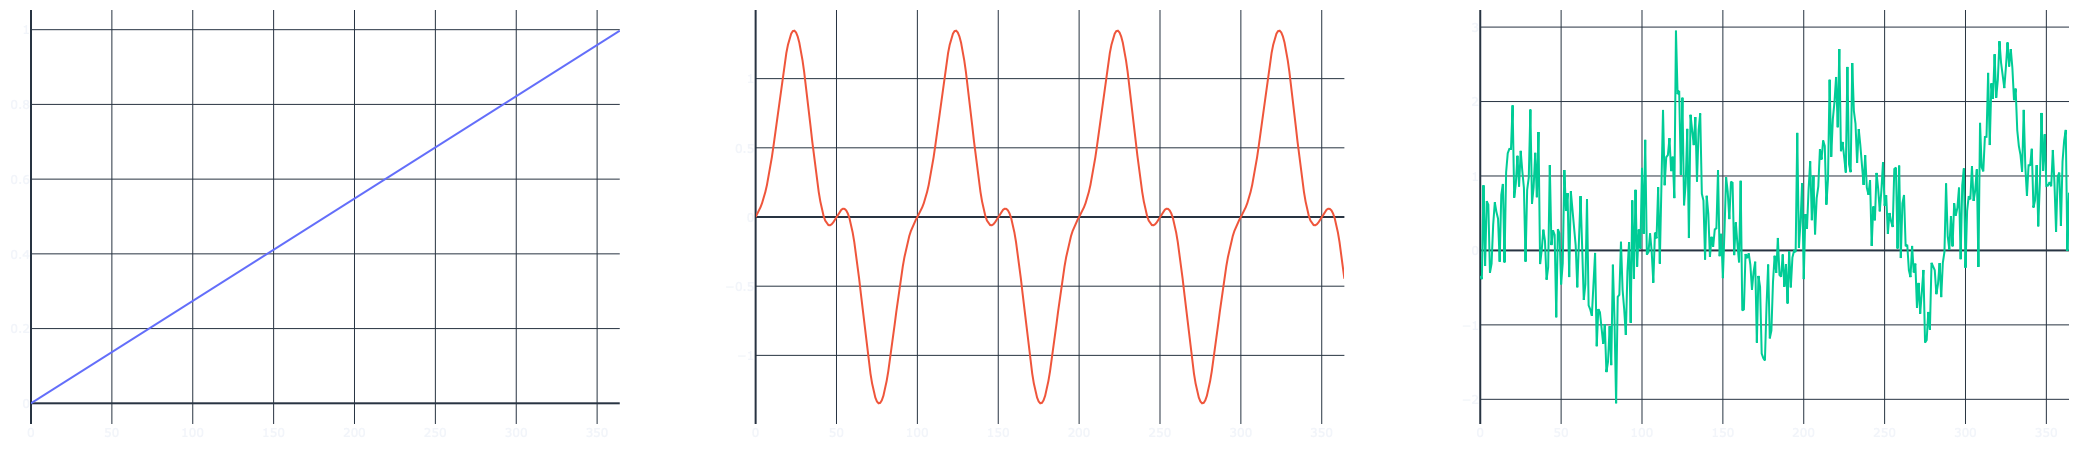

In [4]:
from plotly.subplots import make_subplots

SAVE_TO = '/Users/sebastjancizel/Documents/MyWebpage.tmp/sebastjancizel.github.io/images/'

fig = make_subplots(rows=1, cols=3)

trend_series = trend(generate_series(365))
season_series = seasonality(generate_series(365))
combined_series = white_noise(seasonality(trend(generate_series(365))), sigma=0.5)

fig.add_trace(go.Scatter(x=trend_series.index, 
                         y=trend_series.series,
                         name='Trend'
                        ),
                         row=1,
                         col=1,
             )
                                          
             

fig.add_trace(go.Scatter(x=season_series.index, 
                         y=season_series.series,
                         name='Seasonality'
                        ),
                         row=1,
                         col=2,
             ) 
             

fig.add_trace(go.Scatter(x=combined_series.index, 
                         y=combined_series.series,
                         name='Combined with noise'
                        ),
                         row=1,
                         col=3,
             ) 

fig.update_layout(template='plotly_dark', showlegend=False, plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', margin=dict(l=10, r=10, t=10, b=10))
fig.write_image(SAVE_TO + 'time_series_examples.png', width=1580, height=300)
fig.show()

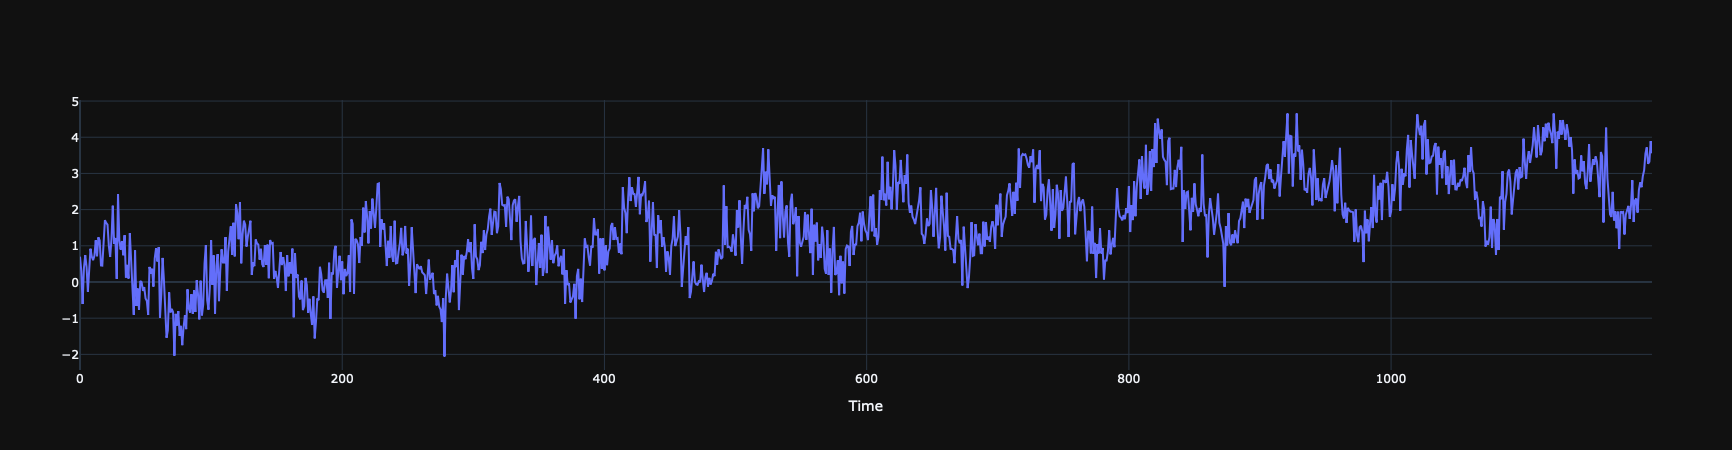

In [5]:
example_series = white_noise(seasonality(trend(generate_series(1200))), sigma=0.5)
plot_series(example_series, plot_title='')

In [6]:
import tensorflow as tf
import keras 
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

Using TensorFlow backend.


We set up the helper function that will slice up the time series into features and labels. This practically means that n time steps are being used as features to predict the n+1 time step (the label).
Conveniently, this is taken care of by the TimeseriesGenerator from the Keras library.

In [7]:
def prepare_data(series, look_back=10, batch_size=1):
    return TimeseriesGenerator(series, series, length=look_back, batch_size=batch_size)

def train_test_split(df, train_share=0.8):
    n = int(df.shape[0] * train_share)
    data = df.series.to_numpy().reshape((-1,1))
    train_data = data[:n]
    test_data = data[n:]
    train_index = df.index[:n].to_numpy()
    test_index = df.index[n:].to_numpy()
    # augmented test data uses data appends the tail of length look_back to test data 
    # this way we can forecast the first data point of the test data set
    augmented_test_data = data[n-look_back:]
    return train_data, train_index, test_data, test_index, augmented_test_data

In [37]:
def build_model(look_back, learning_rate=1e-4):
    '''
    Builds a simple 2 layer LSTM model with LearningRateScheduler callback so that we can tweak the learning rate of the model
    '''
    keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(10,  activation="relu", return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(10, activation="relu"))
    model.add(Dense(1))
    
   
    optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.9)
    
    model.compile(optimizer=optimizer, loss="mse")
    
    return model

In [38]:
look_back = 15
batch_size = 30

train_data, train_index, test_data, test_index, augmented_test_data = train_test_split(example_series)

train_generator = prepare_data(train_data, look_back=look_back, batch_size=batch_size)
test_generator = prepare_data(test_data, look_back=look_back, batch_size=1)
augmented_test_generator = prepare_data(augmented_test_data, look_back=look_back, batch_size=1)

Before we move on let's establish a baseline by using the previous day's value as a prediction for the next day 

In [18]:
naive_pred = np.concatenate((train_data[-1:], test_data[:-1]), axis=0)

print(f'MSE of the naive prediction is {mean_squared_error(naive_pred, test_data)}')
print(f'MAE of the naive prediction is {mean_absolute_error(naive_pred, test_data)}')

MSE of the naive prediction is 0.40846881683394276
MAE of the naive prediction is 0.5135561915646266


In [22]:
lr_schedule = keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-4 * 10**(epoch/15)
    )
model = build_model(look_back)

history=model.fit_generator(train_generator, epochs=40, verbose=1, callbacks=[lr_schedule])

Epoch 1/40
32/32 [==============================] - 3s 84ms/step - loss: 2.7974
Epoch 2/40
32/32 [==============================] - 1s 27ms/step - loss: 2.2296
Epoch 3/40
32/32 [==============================] - 1s 27ms/step - loss: 1.7084
Epoch 4/40
32/32 [==============================] - 1s 27ms/step - loss: 1.1173
Epoch 5/40
32/32 [==============================] - 1s 27ms/step - loss: 0.6078
Epoch 6/40
32/32 [==============================] - 1s 27ms/step - loss: 0.4665
Epoch 7/40
32/32 [==============================] - 1s 27ms/step - loss: 0.4362
Epoch 8/40
32/32 [==============================] - 1s 27ms/step - loss: 0.4282
Epoch 9/40
32/32 [==============================] - 1s 27ms/step - loss: 0.4188
Epoch 10/40
32/32 [==============================] - 1s 27ms/step - loss: 0.4088
Epoch 11/40
32/32 [==============================] - 1s 27ms/step - loss: 0.4123
Epoch 12/40
32/32 [==============================] - 1s 27ms/step - loss: 0.3983
Epoch 13/40
32/32 [==================

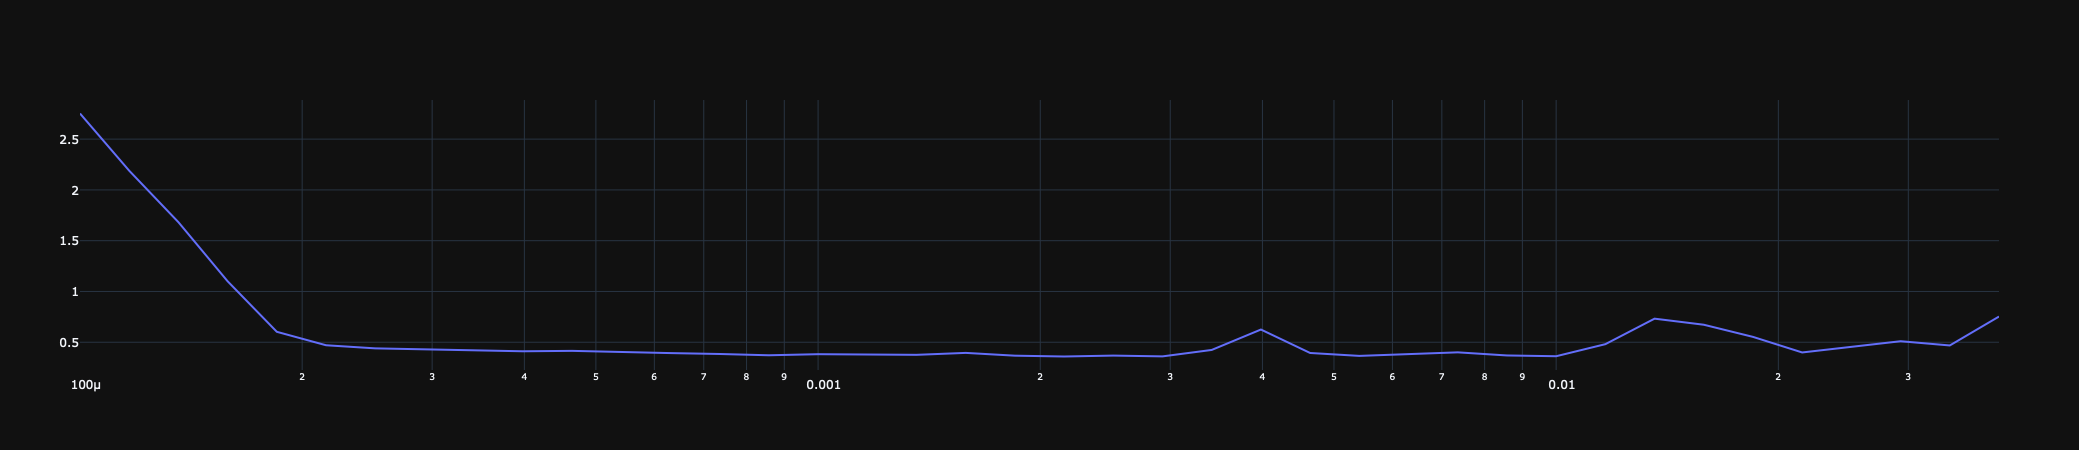

In [35]:
lrs = 1e-4 * (10 ** (np.arange(40) / 15))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x = lrs,
    y = history.history["loss"],
    name = 'Loss for a given learning rate'
                )
)

fig.update_layout(xaxis_type='log', template='plotly_dark')

fig.show()

This shows that learning rate around 1e-3 seems to do pretty well.

In [39]:
model = build_model(look_back, learning_rate=1e-3)
history = model.fit_generator(train_generator, epochs=100, verbose=0)

In [40]:
prediction = model.predict_generator(augmented_test_generator)

train_data = train_data.reshape((-1))
test_data = test_data.reshape((-1))
prediction = prediction.reshape((-1))

In [41]:
from keras.metrics import mse

print(f'The mean square error of the RNN prediction is {mse(prediction, test_data)}.')

The mean square error of the RNN prediction is 0.2804790139198303.


We have easily improved on the score given by the naive prediction.

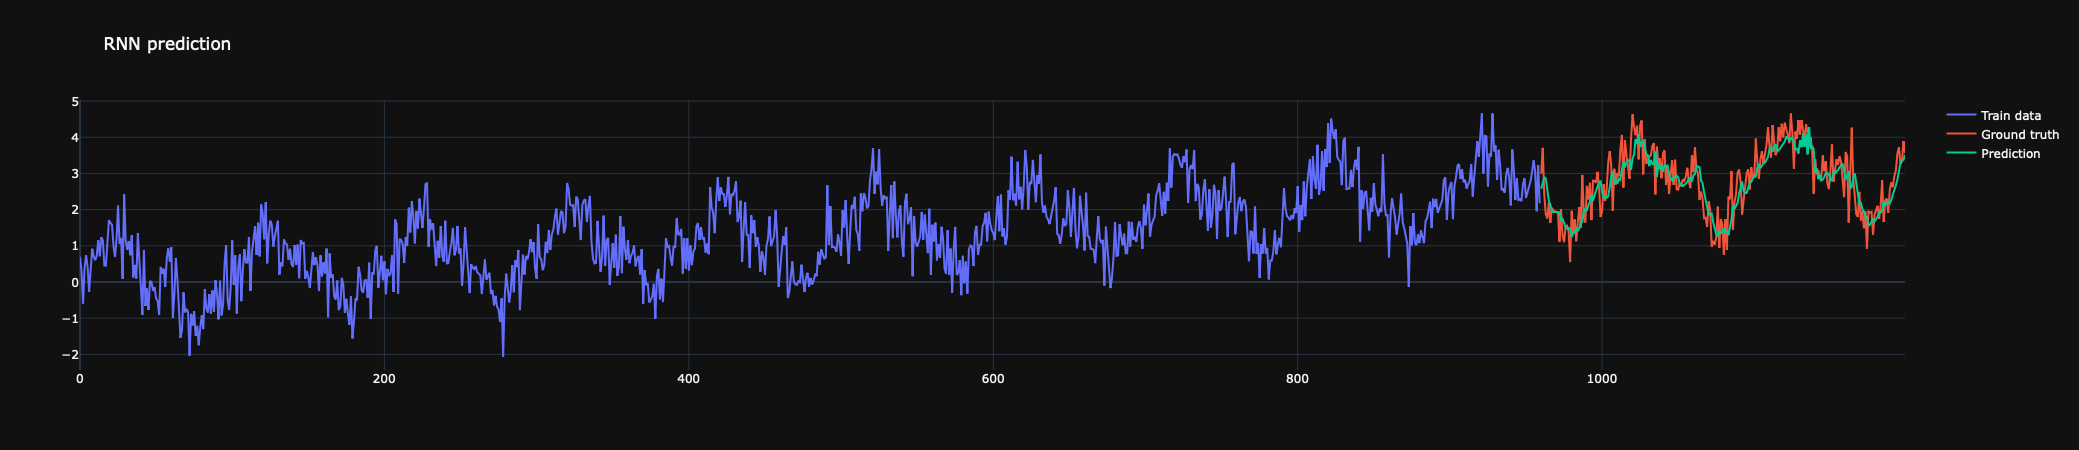

In [42]:
plot_forecast(train_data,train_index, test_data, test_index, prediction, plot_title='RNN prediction', save_image=True)

The plot confirms that the neural network is picking out the pattern reasonably well. It is able to detect the qualitative features of the signal function.

In [45]:
import plotly.io as pio

pio.write_html(fig, file='fig.html', include_plotlyjs='cdn', auto_open=True)